In [109]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [110]:
n_args_count_ = 1  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [111]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [112]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [113]:
def draw_distribution_graphic(best_values, function_name, c):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10) + c, c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10)+c - 2,
                     numpy.zeros(10)+c + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [114]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight, c=0):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name, c)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [115]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [116]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.0036117   0.00804697]
The function value of pqbest:		0.015431685913689819
Algorithm running time:			2.953676462173462 s


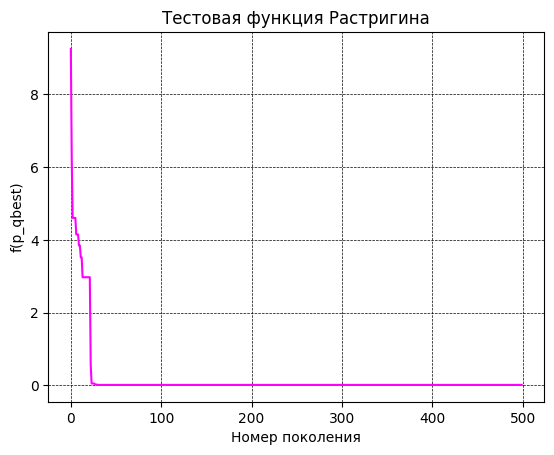

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.9539181  -0.00135704]
The function value of pqbest:		1.3265751362827487
Algorithm running time:			0.01900458335876465 s


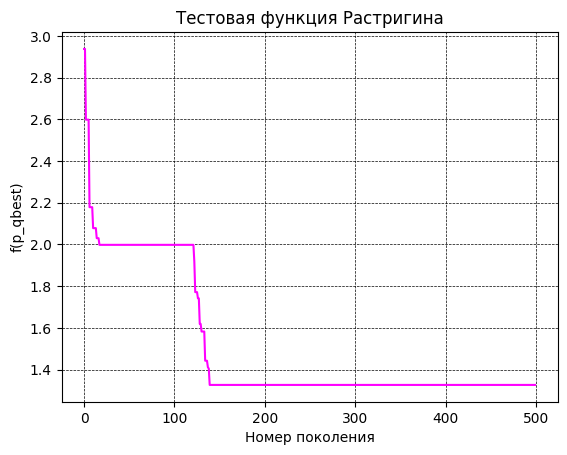

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 1.05360466 -0.09219468]
The function value of pqbest:		3.311848803672863
Algorithm running time:			0.020003557205200195 s


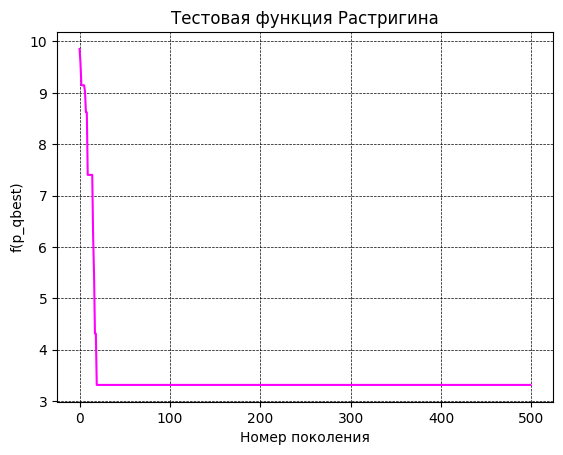

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.03875799 -0.01322897]
The function value of pqbest:		0.3312583975402674
Algorithm running time:			0.020009279251098633 s


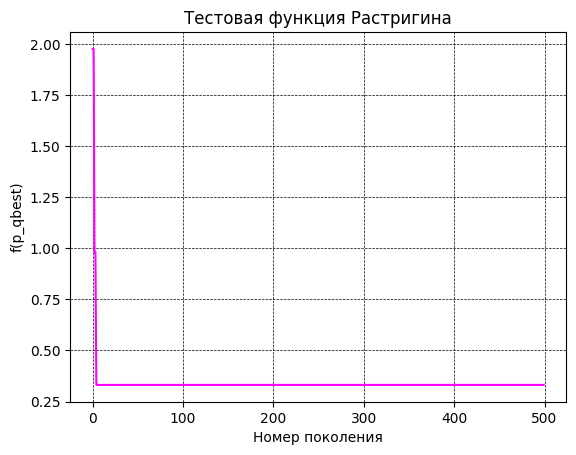

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.96662083 -0.98681931]
The function value of pqbest:		2.1615648408500476
Algorithm running time:			0.020016908645629883 s


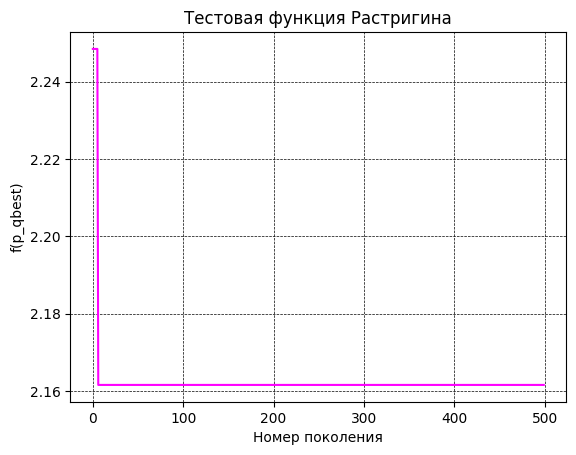

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.00117499 0.00334227]
The function value of pqbest:		0.0024900041060682554
Algorithm running time:			0.01900315284729004 s


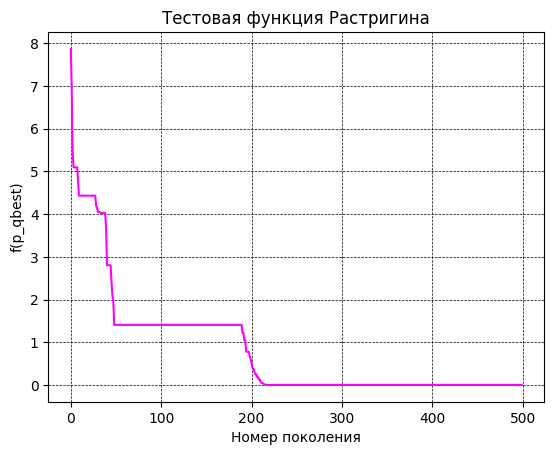

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.00624987 0.98339772]
The function value of pqbest:		1.0291784153596062
Algorithm running time:			0.019021034240722656 s


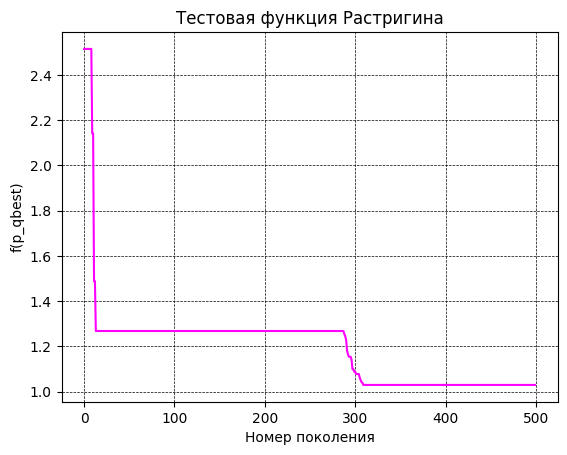

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.01033554 0.00552613]
The function value of pqbest:		0.02724344386081512
Algorithm running time:			0.021011829376220703 s


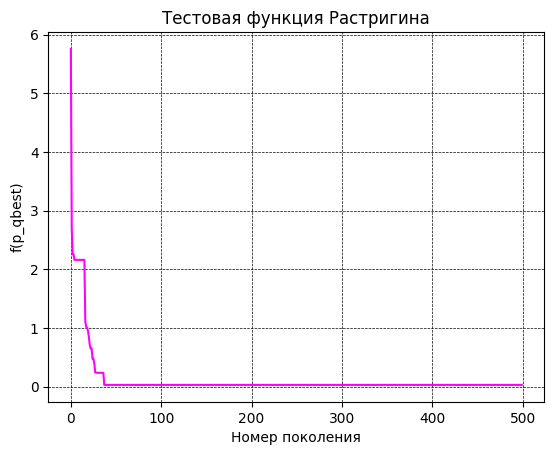

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-1.02059005  1.02959752]
The function value of pqbest:		2.3576631600963047
Algorithm running time:			0.01999831199645996 s


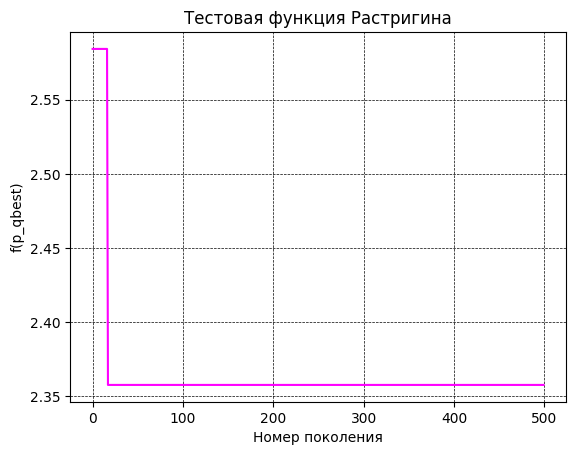

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[0.98482076 0.02795236]
The function value of pqbest:		1.1699329992037093
Algorithm running time:			0.020006418228149414 s


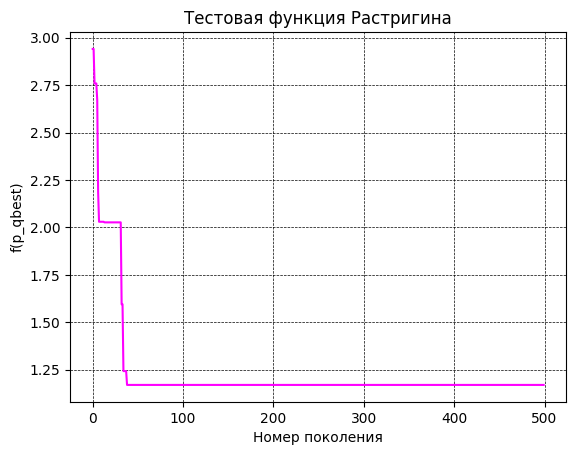

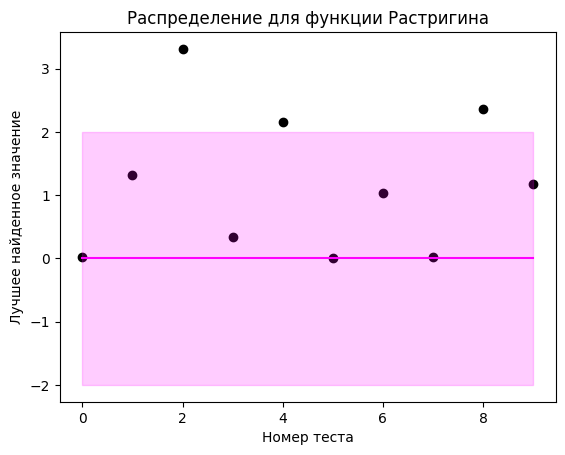

In [117]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [118]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [119]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.95470333  0.02042104]
The function value of pqbest:		2.5915482116118724
Algorithm running time:			2.790181875228882 s


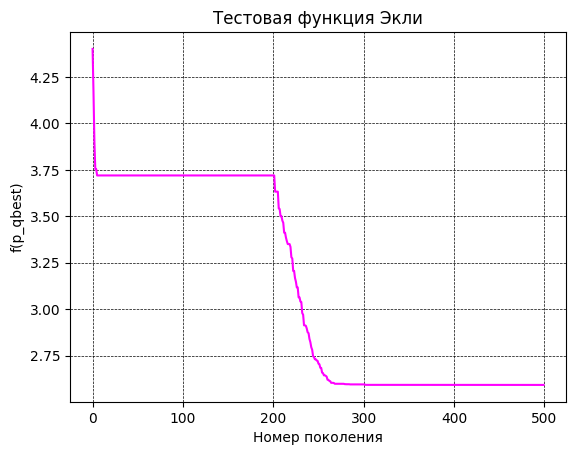

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.00464942 -0.01099104]
The function value of pqbest:		0.03754281734180864
Algorithm running time:			0.020009279251098633 s


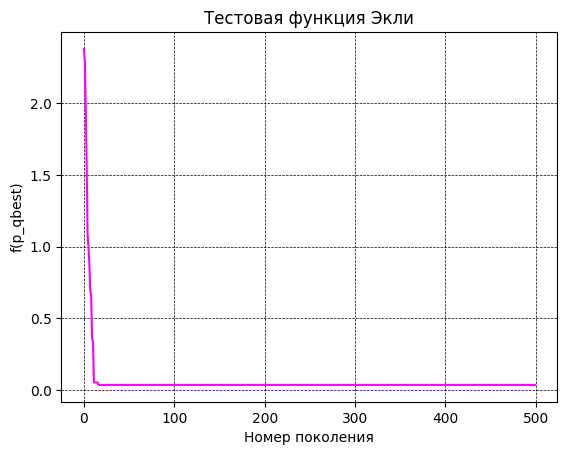

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.18602328  0.07396954]
The function value of pqbest:		1.3751792809450478
Algorithm running time:			0.022017240524291992 s


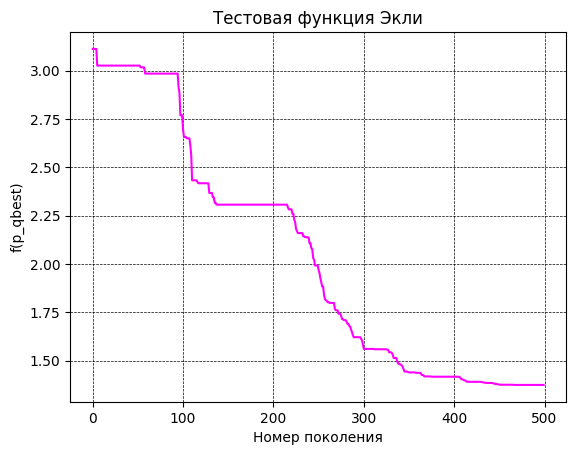

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.00640123  0.21931386]
The function value of pqbest:		1.5155687952560761
Algorithm running time:			0.020999670028686523 s


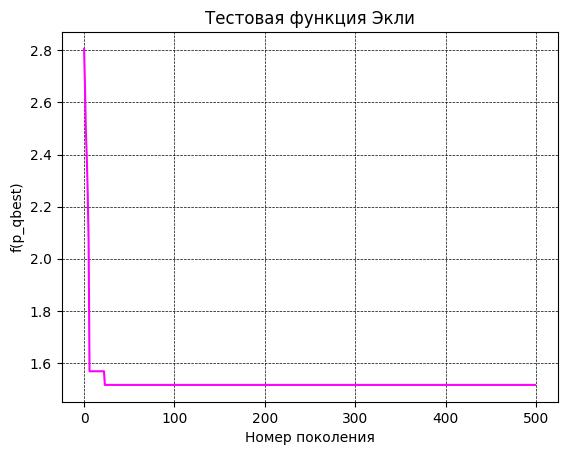

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.16621344 -0.25046895]
The function value of pqbest:		2.2669781571945933
Algorithm running time:			0.021004438400268555 s


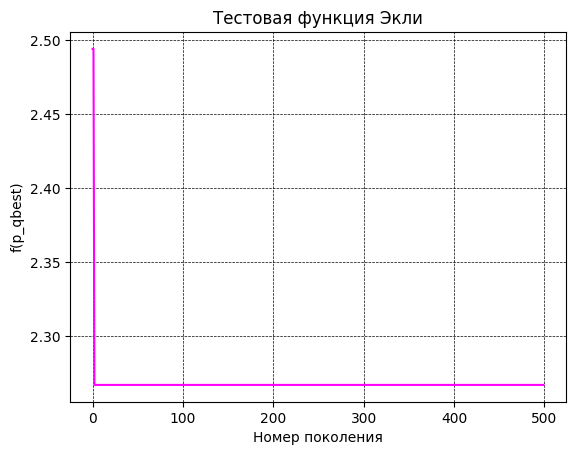

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.13765993  0.23630493]
The function value of pqbest:		2.0331777928900294
Algorithm running time:			0.021010637283325195 s


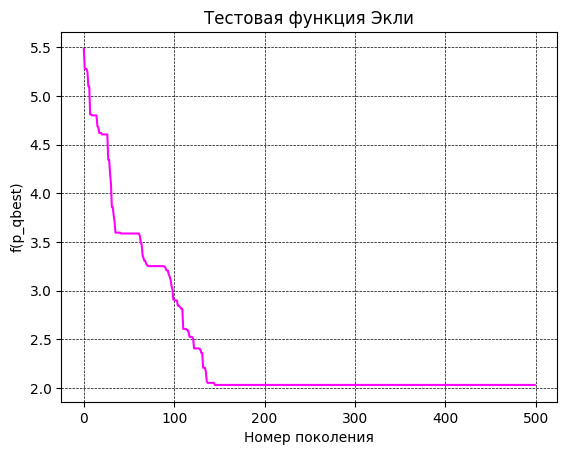

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.04443966  0.03153937]
The function value of pqbest:		0.23163596579903611
Algorithm running time:			0.021004915237426758 s


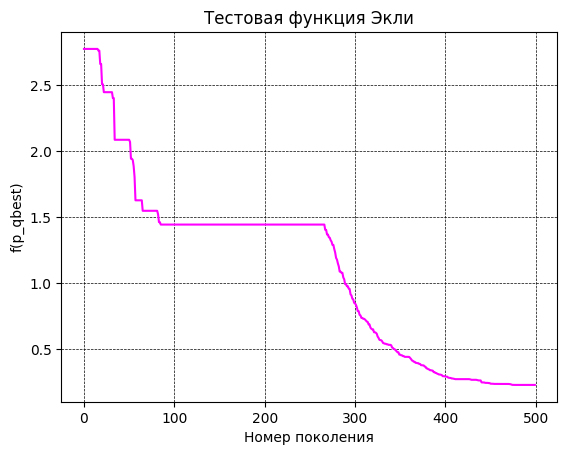

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.0007979   0.00131332]
The function value of pqbest:		0.004409332499591301
Algorithm running time:			0.021004676818847656 s


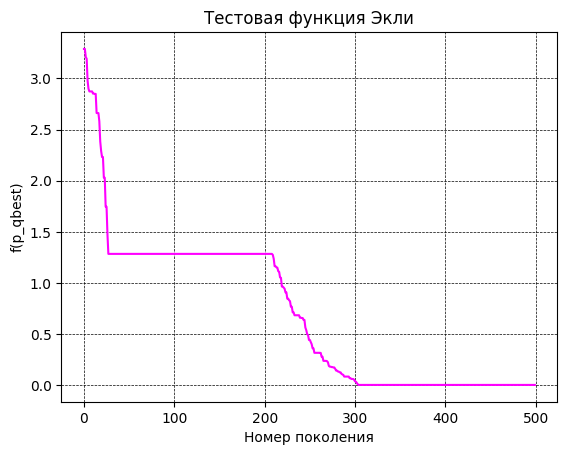

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[0.01868269 0.96241791]
The function value of pqbest:		2.5921183507644514
Algorithm running time:			0.021010160446166992 s


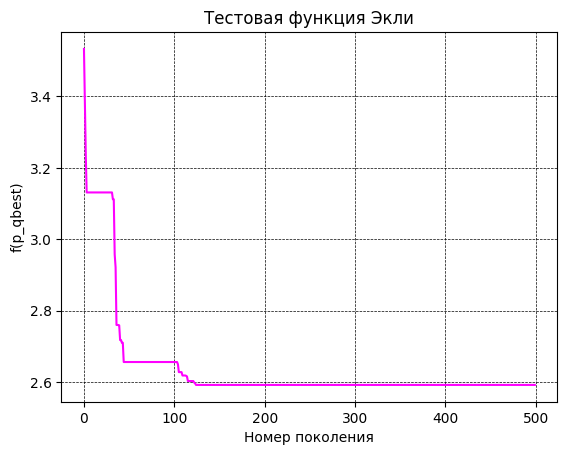

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.16470632 -1.02170277]
The function value of pqbest:		3.32285530708538
Algorithm running time:			0.02199387550354004 s


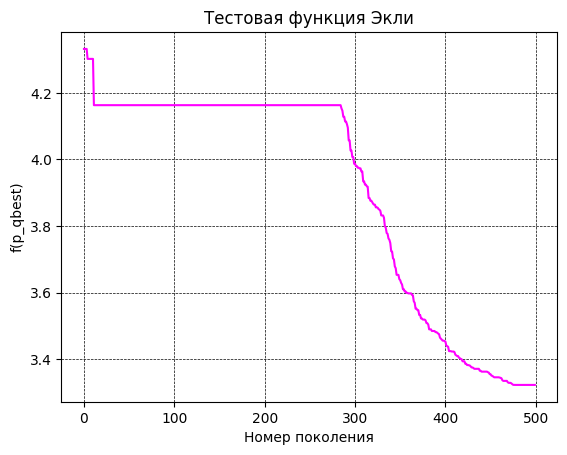

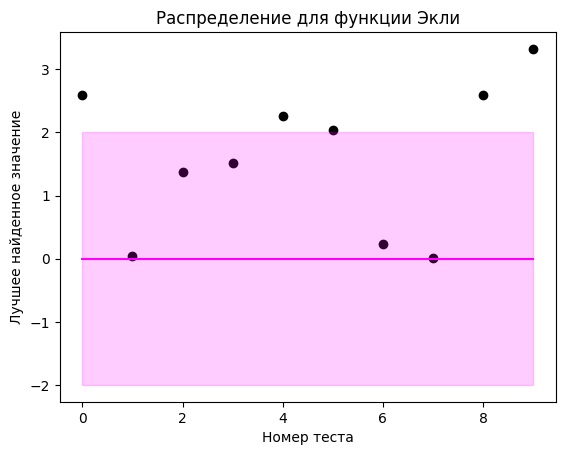

In [120]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [121]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [122]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.06096871 0.13315994]
The function value of pqbest:		0.021448753957243098
Algorithm running time:			3.049193859100342 s


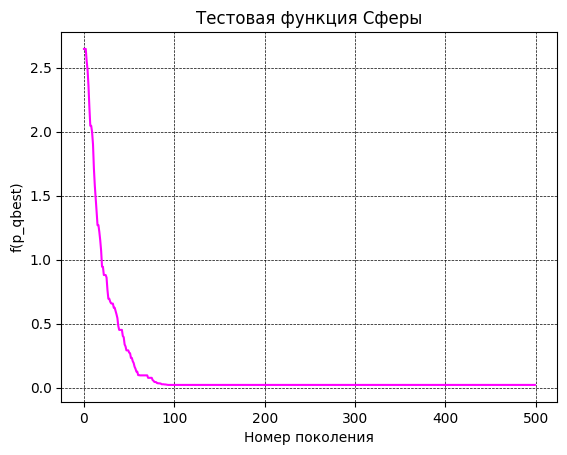

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.01509626 0.00152348]
The function value of pqbest:		0.00023021814123990708
Algorithm running time:			0.0210111141204834 s


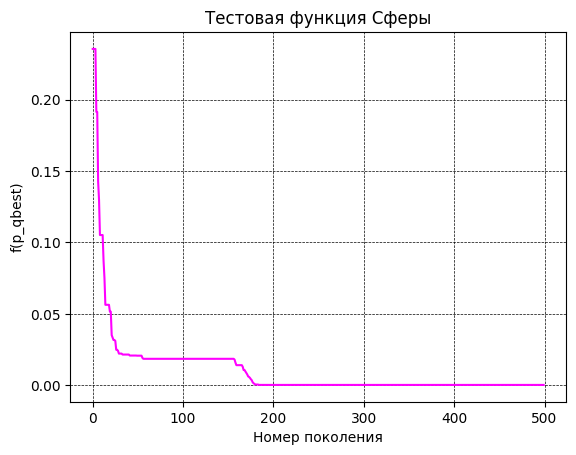

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.14911717  0.32570931]
The function value of pqbest:		0.1283224822772194
Algorithm running time:			0.019021987915039062 s


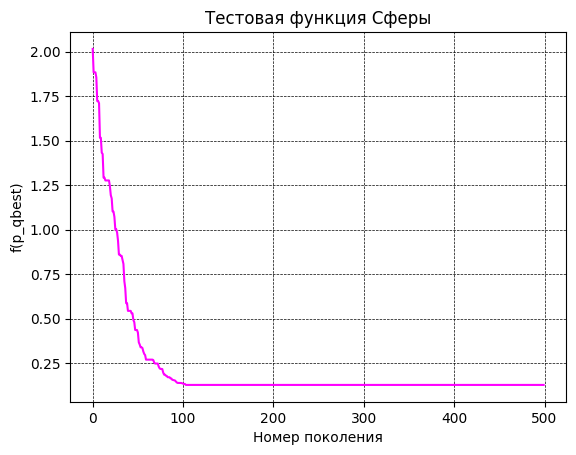

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.03505002 0.14755512]
The function value of pqbest:		0.023001015774996837
Algorithm running time:			0.01800084114074707 s


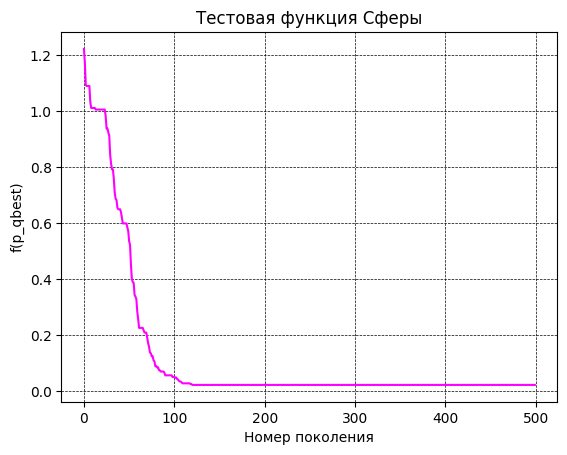

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.29533162  0.32471607]
The function value of pqbest:		0.19266129005597846
Algorithm running time:			0.019009828567504883 s


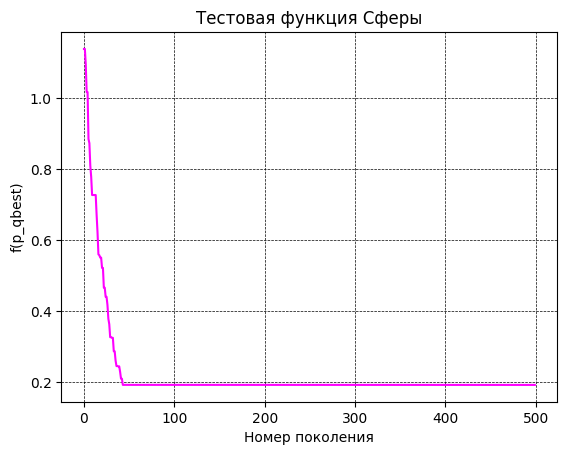

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-6.22594479e-05 -7.39597892e-03]
The function value of pqbest:		5.470438041759443e-05
Algorithm running time:			0.019011497497558594 s


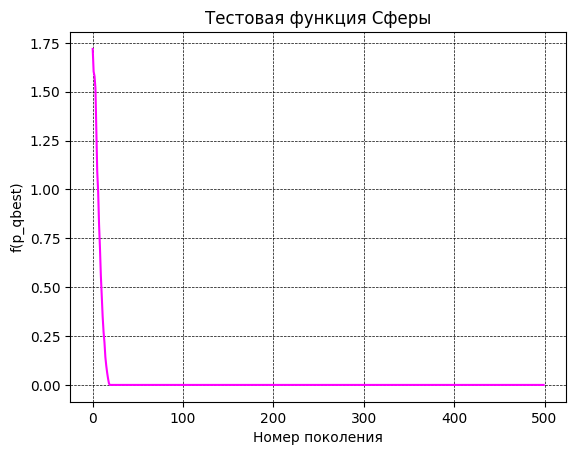

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.13816381  0.84240897]
The function value of pqbest:		0.7287421183112471
Algorithm running time:			0.020005464553833008 s


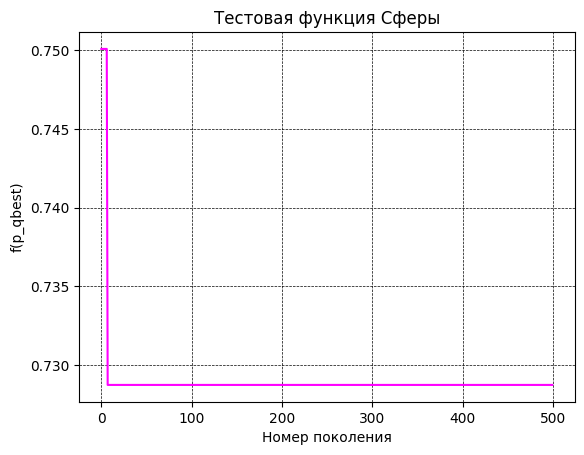

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.00228899 -0.00314106]
The function value of pqbest:		1.5105738554301875e-05
Algorithm running time:			0.01901531219482422 s


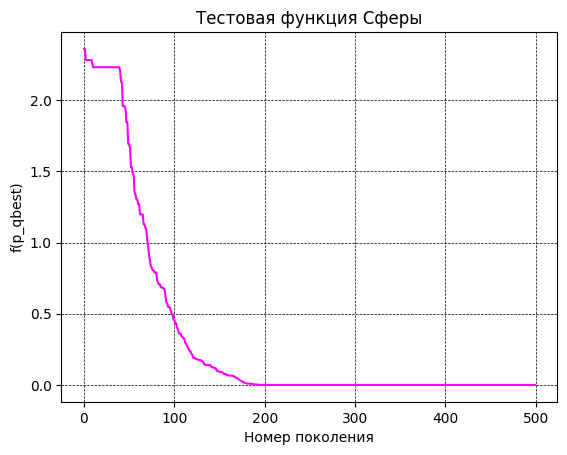

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.33750371 0.37178759]
The function value of pqbest:		1.9271421878131676
Algorithm running time:			0.01799631118774414 s


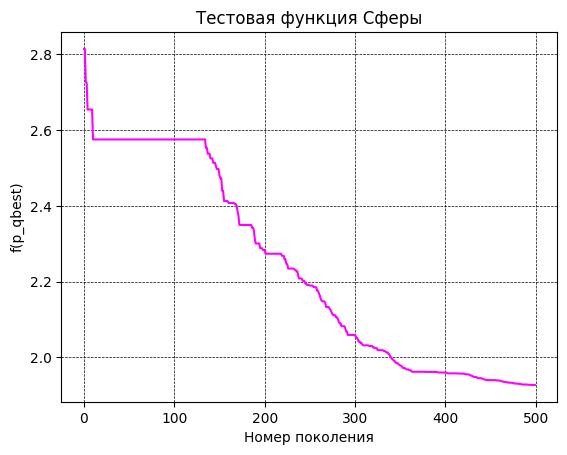

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.15660419 -0.16794115]
The function value of pqbest:		0.052729099925351464
Algorithm running time:			0.020016193389892578 s


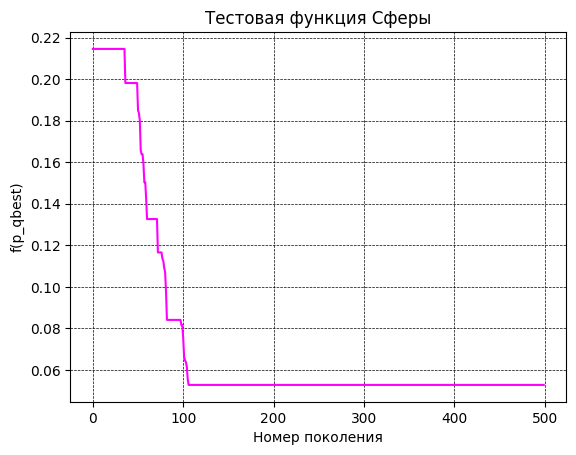

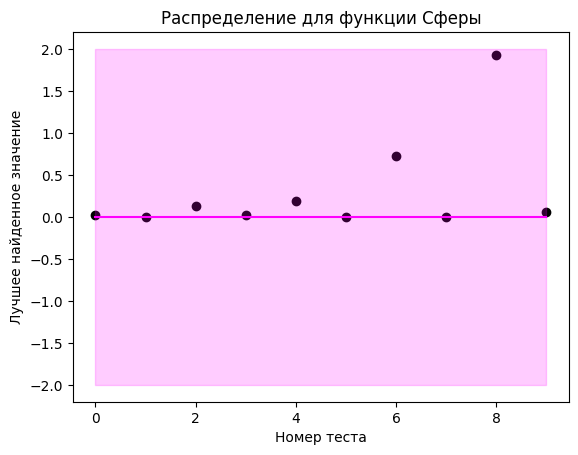

In [123]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)



##Тестовая функция Розенбока
![picture_of_Rosenbock](src/розенбока.png)

In [124]:
@njit
def f4(x):  # Тестовая функция Розенбока
    result = 0
    n = len(x)
    for i in range(n-1):
        result += 100 * (x[i+1] - x[i] ** 2) **2 + (x[i] - 1) **2
    return result

##Генерация начальных агентов

In [125]:
@njit
def generate_agents4(number_of_agents, n_args_count):
    return numpy.random.uniform(-11, 11, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[1.00768129 1.01491119]
The function value of pqbest:		8.505204058919369e-05
Algorithm running time:			2.885810136795044 s


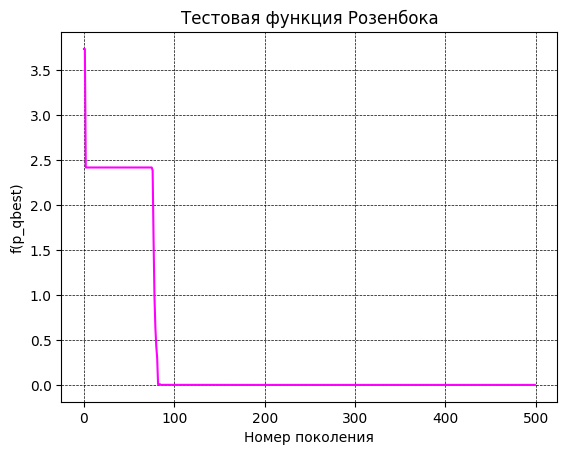

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.69958943  0.54027288]
The function value of pqbest:		3.1471510992355185
Algorithm running time:			0.018016815185546875 s


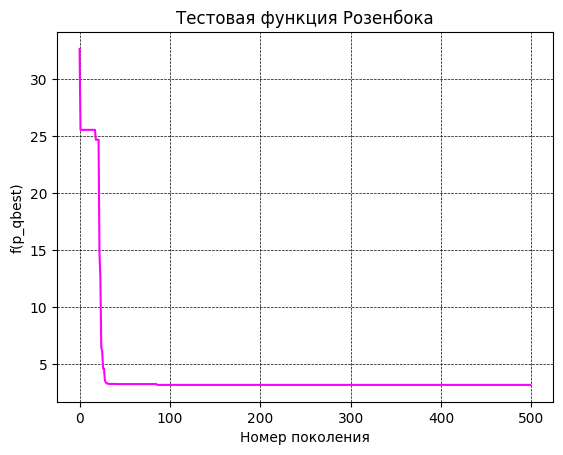

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.75602835 3.06135156]
The function value of pqbest:		0.6212364918115676
Algorithm running time:			0.02100515365600586 s


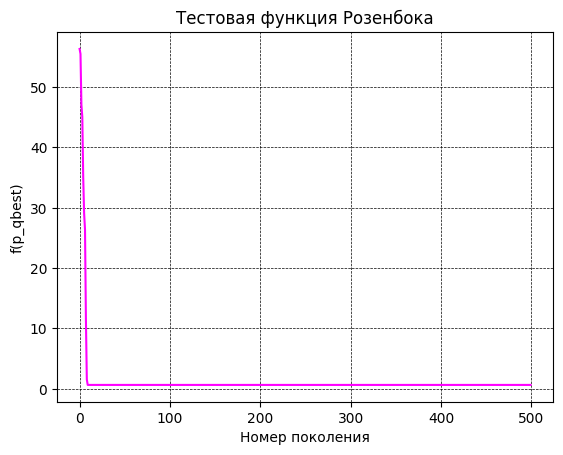

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[2.59578619 6.74117875]
The function value of pqbest:		2.5474777779599522
Algorithm running time:			0.01900315284729004 s


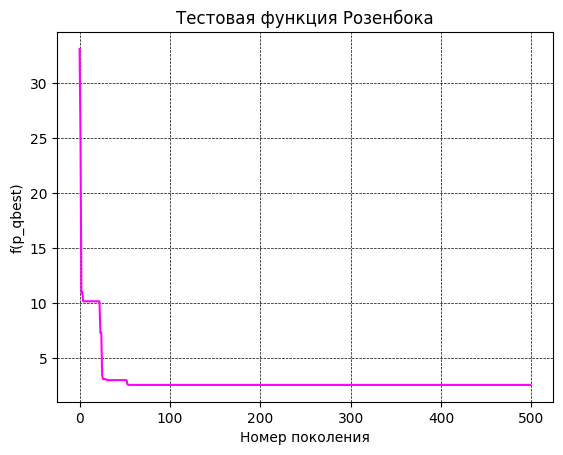

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[1.30289145 1.70013929]
The function value of pqbest:		0.09242608999796305
Algorithm running time:			0.020020723342895508 s


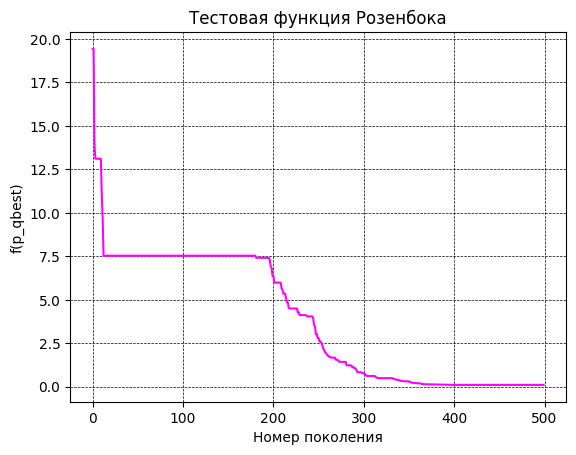

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-1.81495794  3.30903212]
The function value of pqbest:		7.9463677683477805
Algorithm running time:			0.018003225326538086 s


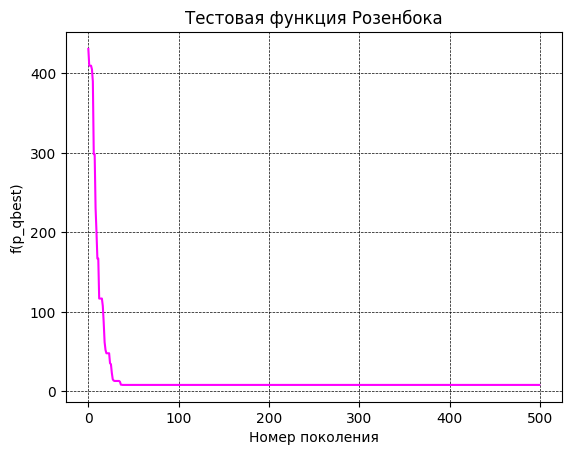

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[2.28673429 5.22885796]
The function value of pqbest:		1.6556938902450786
Algorithm running time:			0.019004344940185547 s


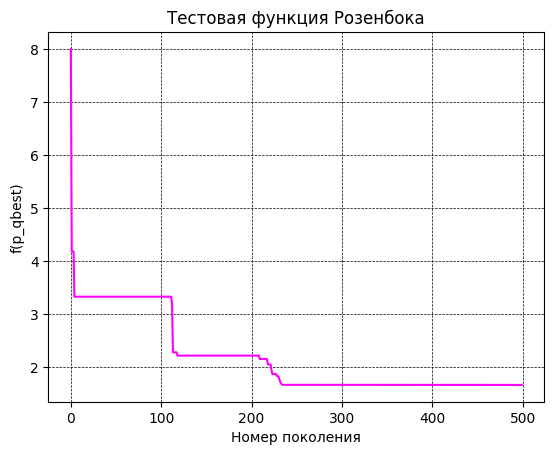

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[1.35302458 1.83816717]
The function value of pqbest:		0.13023883185836801
Algorithm running time:			0.01801156997680664 s


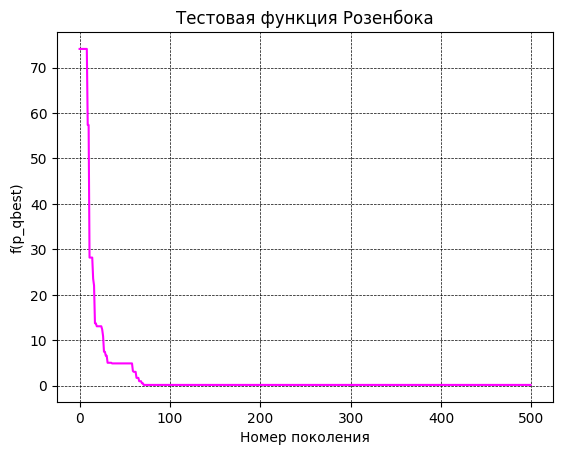

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.57859479 2.50086481]
The function value of pqbest:		0.34269879128130903
Algorithm running time:			0.018004655838012695 s


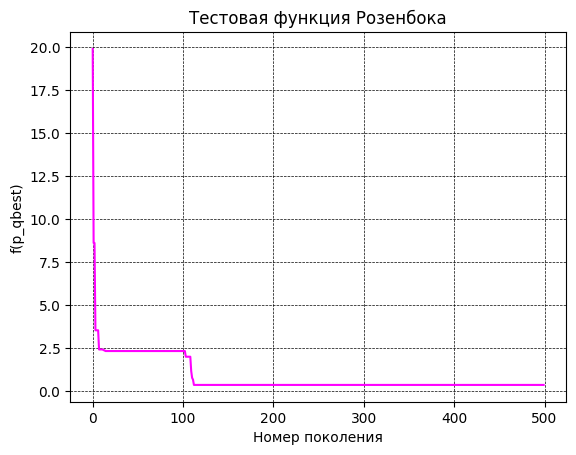

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[2.37175387 5.50428623]
The function value of pqbest:		3.3441191061500706
Algorithm running time:			0.020011186599731445 s


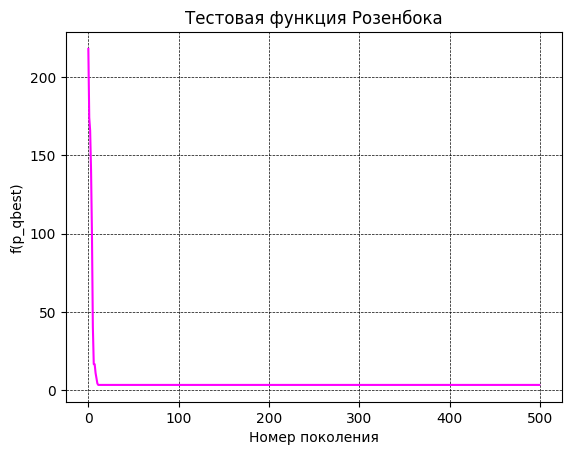

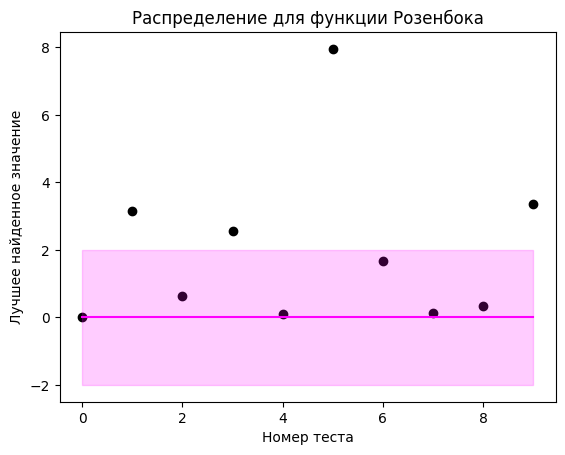

In [126]:
start_test(f4, generate_agents4, "Розенбока", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Била
![picture_of_Bila](src/била.png)

In [127]:
@njit
def f5(x):  # Тестовая функция Била
    result = (1.5 - x[0] + x[0] * x[1]) ** 2 + \
             (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + \
             (2.625 - x[0] + x[0] * x[1] ** 3) ** 2
    return result

In [128]:
@njit
def generate_agents5(number_of_agents, n_args_count):
    return numpy.random.uniform(-4.5, 4.5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[3.130926   0.53139921]
The function value of pqbest:		0.002392408760364592
Algorithm running time:			2.867342948913574 s


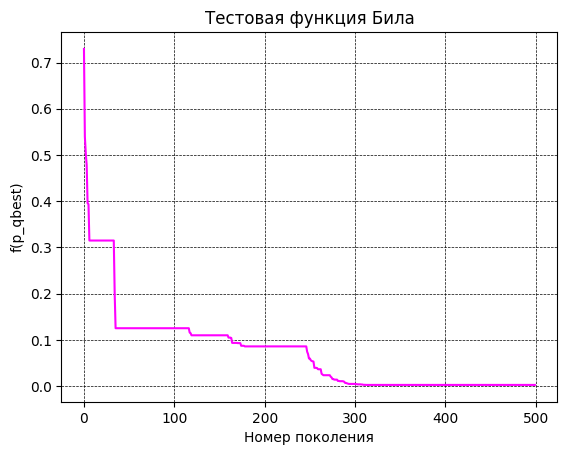

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[3.81596731 0.64770601]
The function value of pqbest:		0.04918423705037138
Algorithm running time:			0.01900458335876465 s


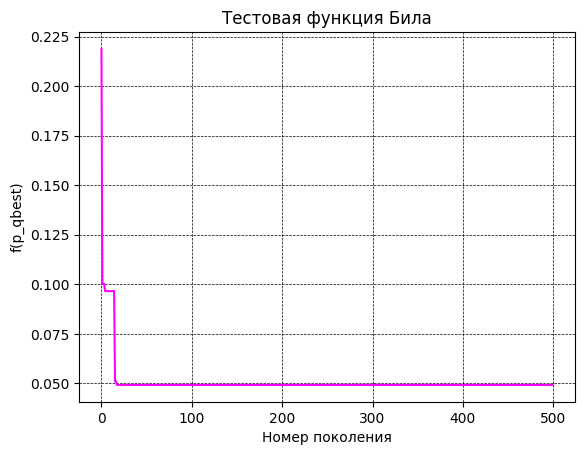

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[2.67706718 0.40717948]
The function value of pqbest:		0.02440672124877376
Algorithm running time:			0.019014358520507812 s


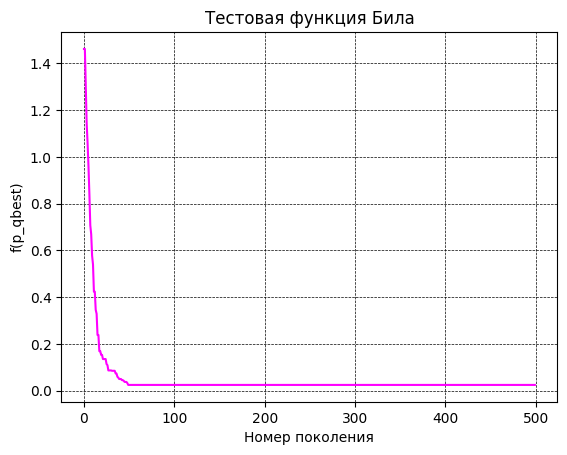

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[2.58808726 0.38996983]
The function value of pqbest:		0.045543570902003755
Algorithm running time:			0.020010709762573242 s


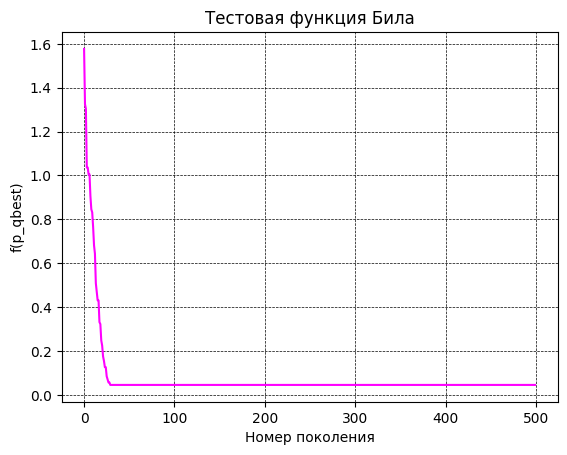

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[2.81383906 0.48043634]
The function value of pqbest:		0.023959948782295577
Algorithm running time:			0.019002676010131836 s


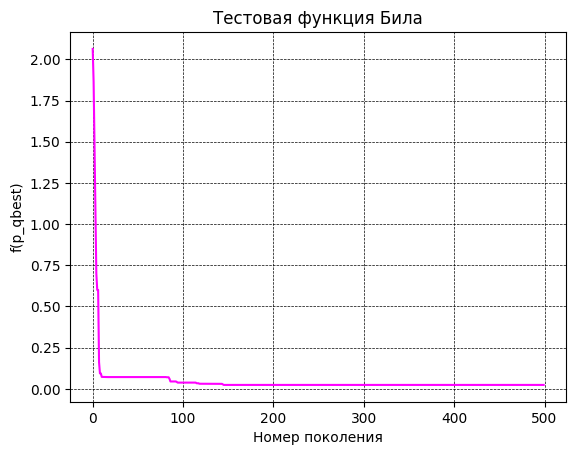

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[2.81090754 0.48111771]
The function value of pqbest:		0.025936749436622254
Algorithm running time:			0.0200040340423584 s


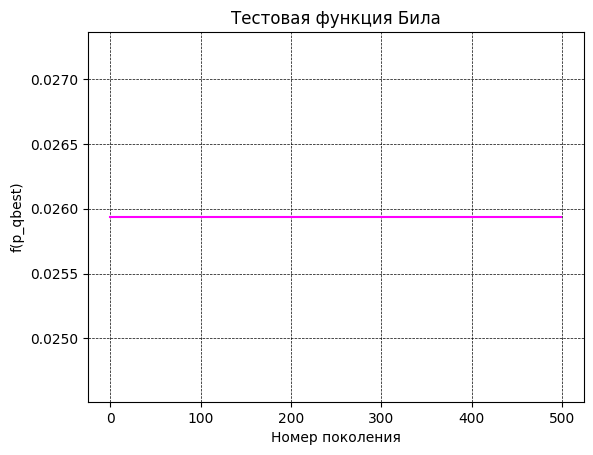

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[2.96722917 0.49428003]
The function value of pqbest:		0.0003185710529996146
Algorithm running time:			0.018002986907958984 s


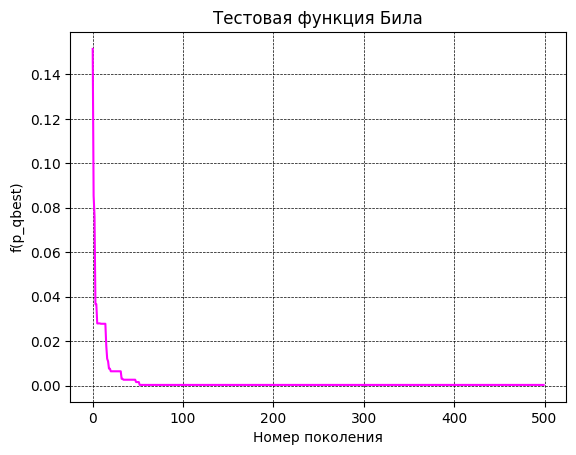

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[3.3601395  0.57445379]
The function value of pqbest:		0.01455266634872392
Algorithm running time:			0.018006324768066406 s


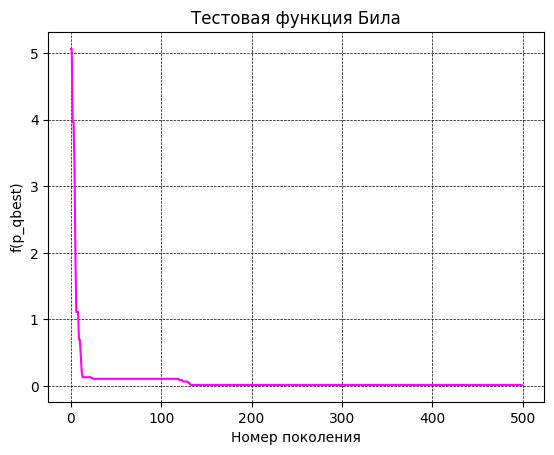

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[3.02668467 0.50819751]
The function value of pqbest:		0.00017620794095525347
Algorithm running time:			0.020991802215576172 s


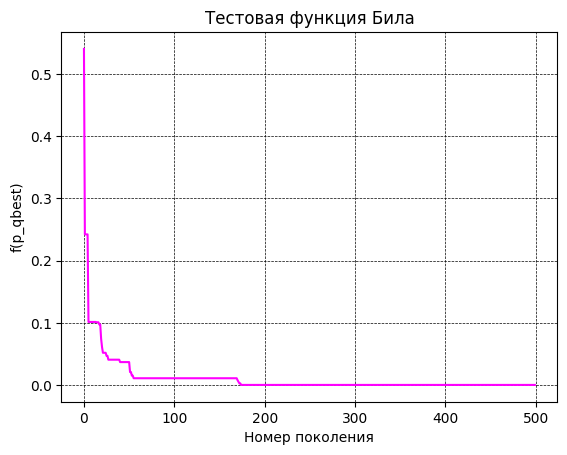

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[3.02087522 0.5114311 ]
The function value of pqbest:		0.0010196072639955995
Algorithm running time:			0.0200042724609375 s


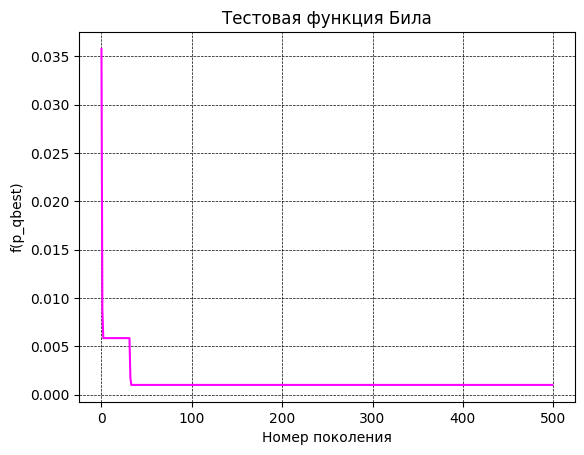

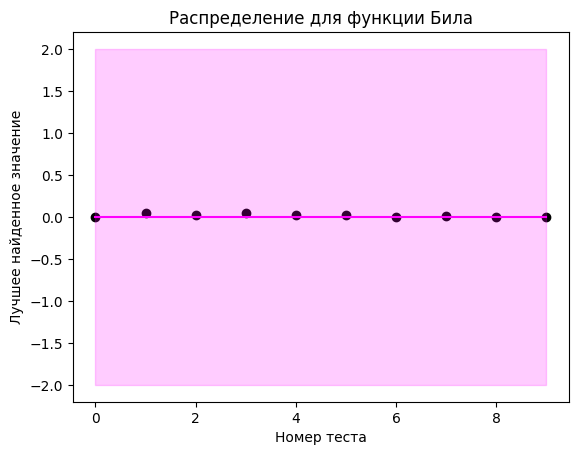

In [129]:
start_test(f5, generate_agents5, "Била", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Гольдшейна-Прайса
![picture_of_Goldsheina_praisa](src/гольдшейна_прайса.png)

In [130]:
@njit
def f6(x):  # Тестовая функция гольдшейна-прайса
    result = (1 + (x[0] + x[1] + 1) ** 2 *
              (19 - 14* x[0] + 3*x[0]**2 - 14 * x[1] + 6 * x[0]*x[1] + 3 * x[1] ** 2)) * \
             (30 + (2*x[0]-3*x[1]) ** 2 * (18 - 32*x[0]+12*x[0]**2+48*x[1] - 36*x[0]*x[1] + 27*x[1]**2))
    return result

In [131]:
@njit
def generate_agents6(number_of_agents, n_args_count):
    return numpy.random.uniform(-2, 2, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.00231114 -1.04145819]
The function value of pqbest:		3.8021377301648016
Algorithm running time:			3.3140437602996826 s


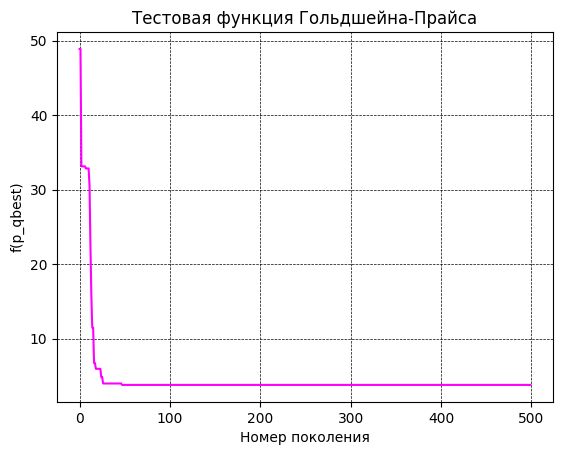

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.0049747  -1.00298942]
The function value of pqbest:		3.0069151976073565
Algorithm running time:			0.019016027450561523 s


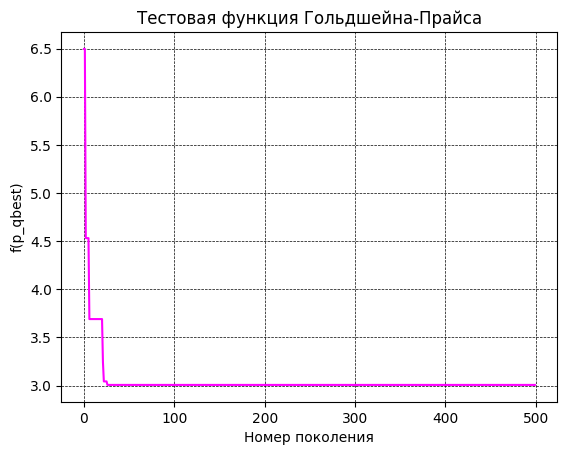

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.36211592 -0.76123666]
The function value of pqbest:		30.173149107775508
Algorithm running time:			0.018009185791015625 s


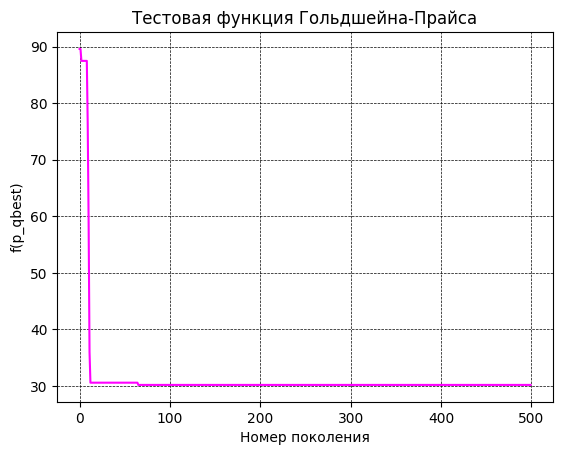

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.07598122 -0.97134168]
The function value of pqbest:		5.173743865752769
Algorithm running time:			0.01900339126586914 s


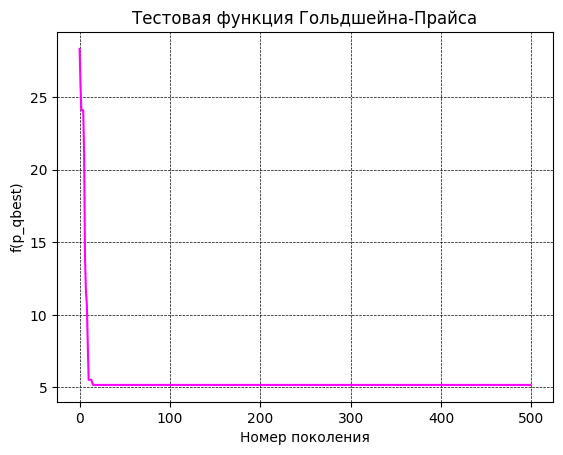

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.00790202 -0.99172968]
The function value of pqbest:		3.030926640462733
Algorithm running time:			0.01900935173034668 s


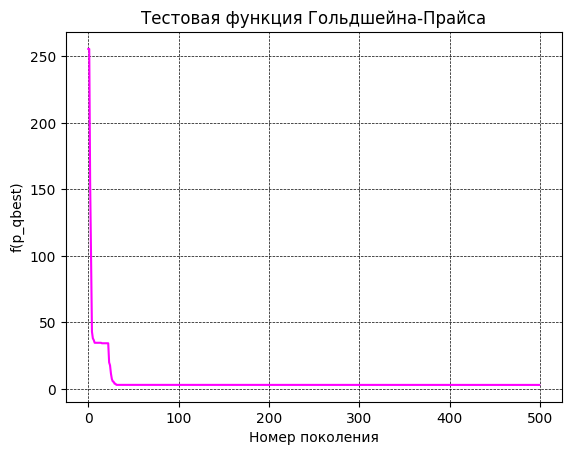

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.07366581 -0.98987972]
The function value of pqbest:		4.6338011497969855
Algorithm running time:			0.018003463745117188 s


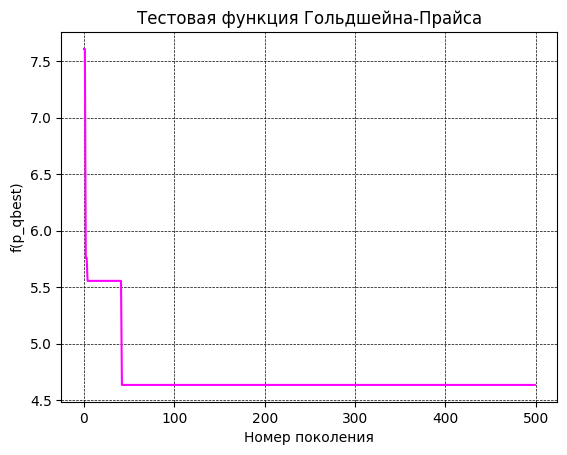

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.00452149 -1.02007915]
The function value of pqbest:		3.2074562820582937
Algorithm running time:			0.018002986907958984 s


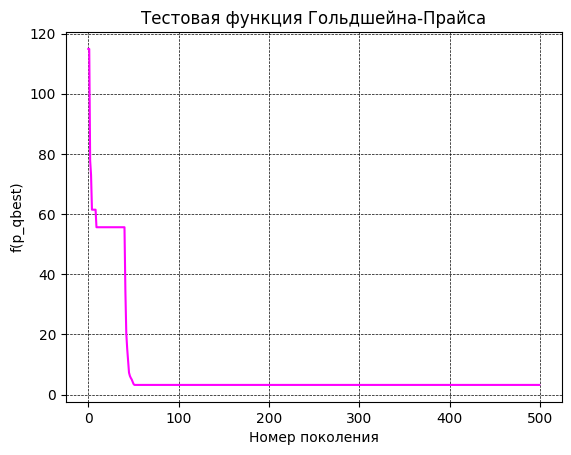

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.00598461 -1.01045144]
The function value of pqbest:		3.071416385449848
Algorithm running time:			0.020010948181152344 s


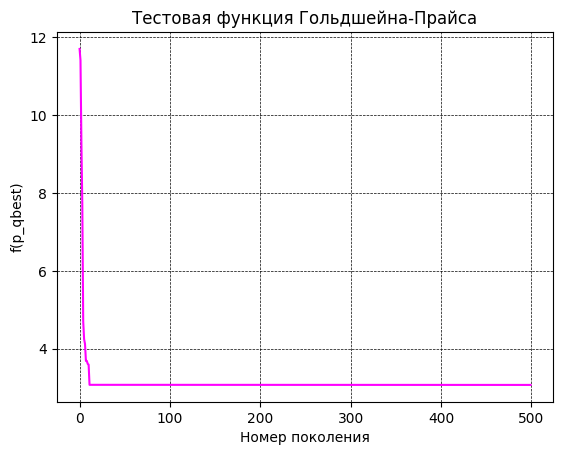

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.04916806 -0.98988424]
The function value of pqbest:		3.7537458822184777
Algorithm running time:			0.018464326858520508 s


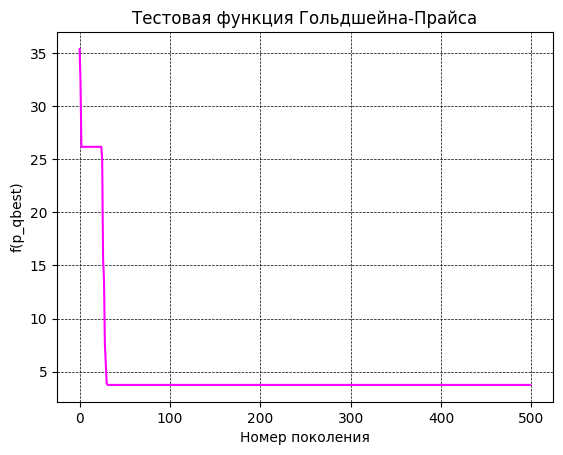

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.08383073 -1.03808987]
The function value of pqbest:		4.872689986526531
Algorithm running time:			0.01801466941833496 s


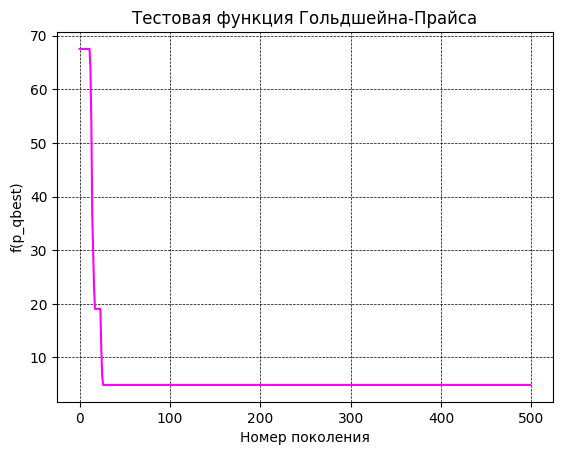

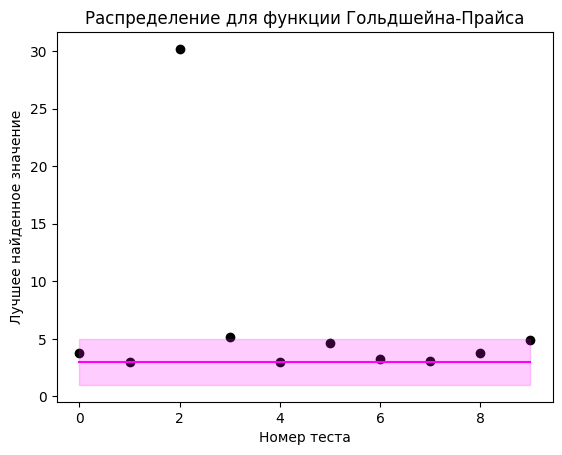

In [132]:
start_test(f6, generate_agents6, "Гольдшейна-Прайса", n_args_count_, iter_max_, number_of_agents_, max_weight_, c=3)

##Тестовая функция Бута
![picture_of_Buta](src/бута.png)

In [133]:
@njit
def f7(x):  # Тестовая функция Бута
    result = (x[0] * 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2
    return result

In [134]:
@njit
def generate_agents7(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.9378545  3.64987528]
The function value of pqbest:		0.2999228419390897
Algorithm running time:			2.7955942153930664 s


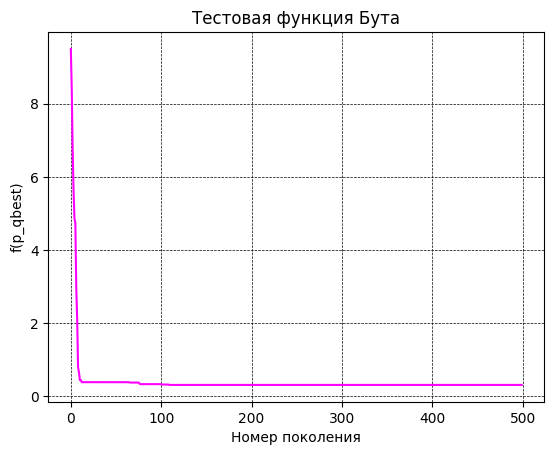

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[2.30828061 1.41321675]
The function value of pqbest:		1.286826745580614
Algorithm running time:			0.019002914428710938 s


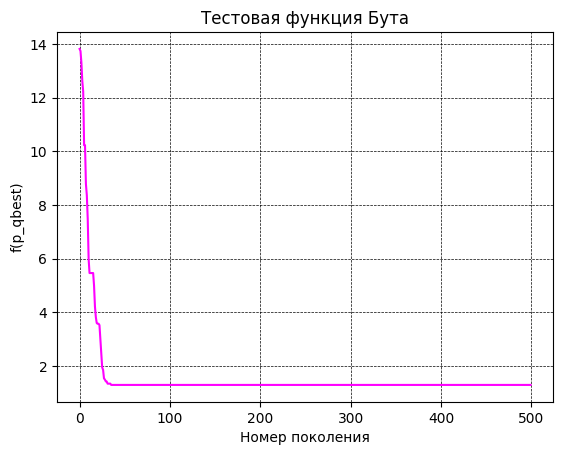

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.50850994 2.28262515]
The function value of pqbest:		0.10261826674077407
Algorithm running time:			0.019002199172973633 s


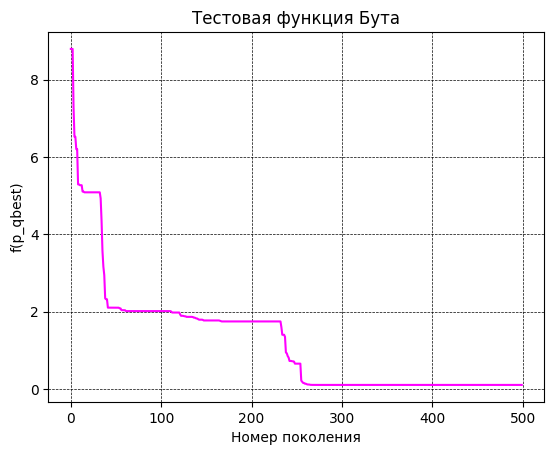

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.68330103 4.98580287]
The function value of pqbest:		1.8637408974455167
Algorithm running time:			0.017004013061523438 s


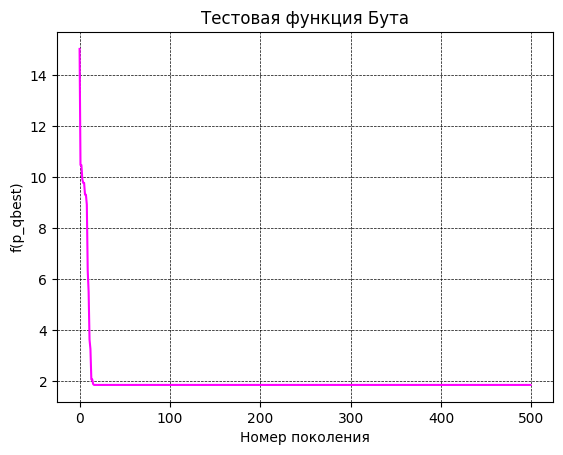

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[1.56844315 2.46389665]
The function value of pqbest:		0.8923281989140716
Algorithm running time:			0.018010616302490234 s


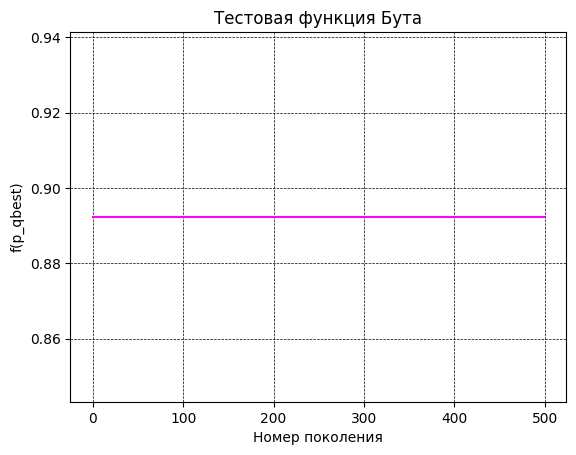

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[2.25134033 1.46480974]
The function value of pqbest:		1.0996009063759398
Algorithm running time:			0.017998218536376953 s


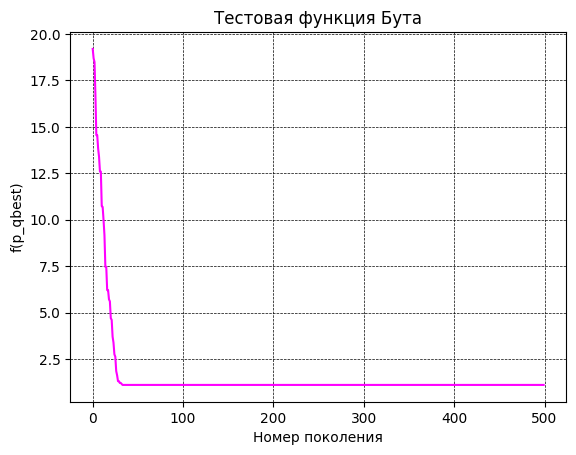

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[1.1375353 3.0290444]
The function value of pqbest:		0.10430382743654498
Algorithm running time:			0.018009424209594727 s


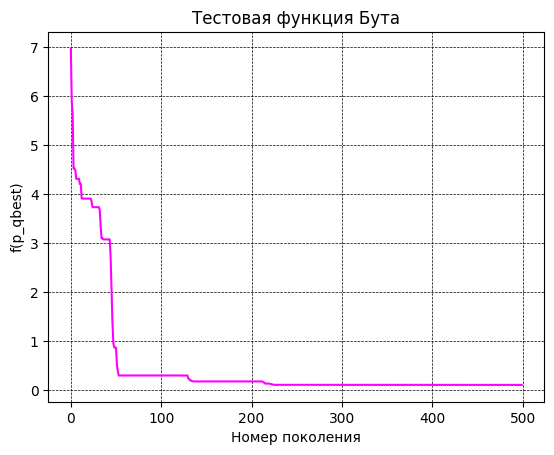

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.82754591 4.1105897 ]
The function value of pqbest:		0.6249184147313136
Algorithm running time:			0.021998167037963867 s


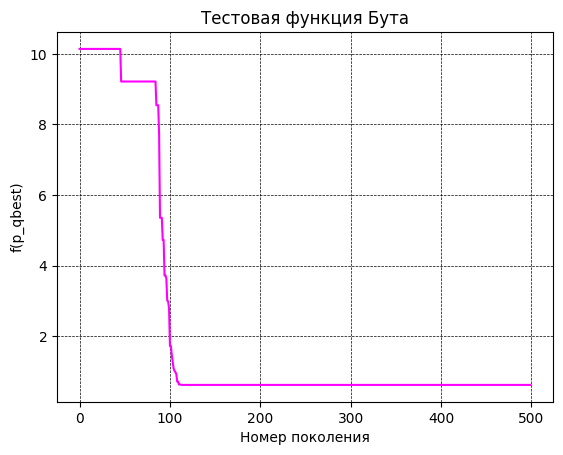

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.29626971 2.66428746]
The function value of pqbest:		0.07455884986492217
Algorithm running time:			0.018002986907958984 s


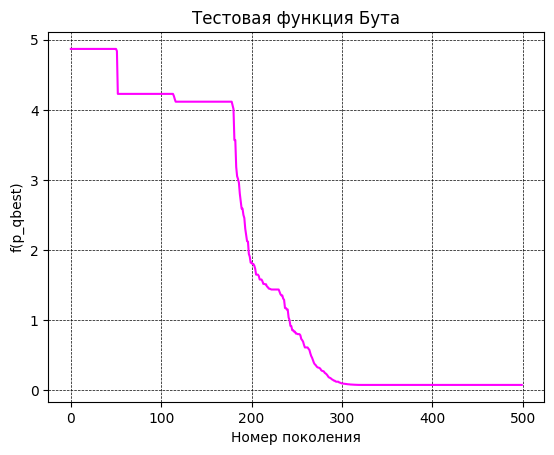

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[1.33486258 2.58958579]
The function value of pqbest:		0.0747274749525477
Algorithm running time:			0.018012523651123047 s


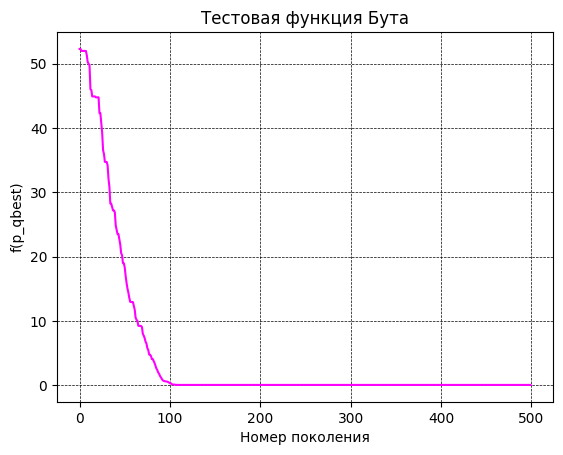

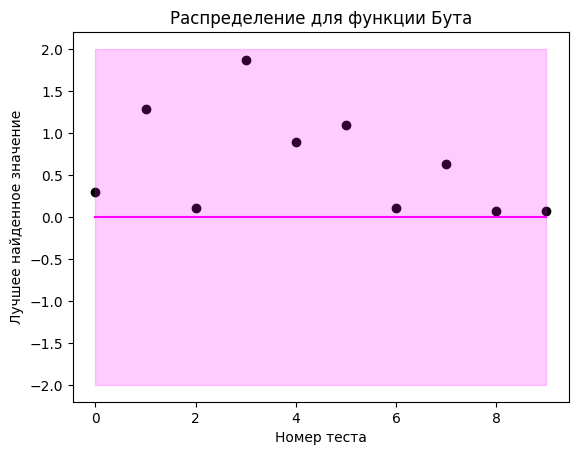

In [135]:
start_test(f7, generate_agents7, "Бута", n_args_count_, iter_max_, number_of_agents_, max_weight_)